In [1]:
#load and process
import pandas as pd
import cv2
import numpy as np


dataset_path = 'Emotion Recognition/FilterEmotionV2.csv'
image_size=(48,48)

def load_fer2013():
        data = pd.read_csv(dataset_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions, data

def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x

In [2]:
#cnn Xception model
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

def simple_CNN(input_shape, num_classes):

    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                            name='image_array', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(.5))

    model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax',name='predictions'))
    return model

def simpler_CNN(input_shape, num_classes):

    model = Sequential()
    model.add(Convolution2D(filters=16, kernel_size=(5, 5), padding='same',
                            name='image_array', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=16, kernel_size=(5, 5),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=32, kernel_size=(5, 5),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=64, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=64, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.25))

    model.add(Convolution2D(filters=256, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=128, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))

    model.add(Convolution2D(filters=256, kernel_size=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3),
                            strides=(2, 2), padding='same'))

    model.add(Flatten())
    #model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax',name='predictions'))
    return model

def tiny_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(5, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(8, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(8, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model


def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

def big_XCEPTION(input_shape, num_classes):
    img_input = Input(input_shape)
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False)(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])
    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

Using TensorFlow backend.


In [3]:
#Start train model

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [4]:
# parameters
batch_size = 32
num_epochs = 10000
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 4
patience = 50
base_path = 'Git_Emotion_recog/models/FilterEmotion4ClassesV2/'


In [5]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


In [6]:
# model parameters/compilation
model = mini_XCEPTION(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [7]:
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-Model.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

In [8]:
# loading dataset
faces, emotions, data = load_fer2013()
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [10]:
data.tail()

,emotion,pixels
12595,3,251 250 253 223 111 74 79 94 110 112 106 102 1...
12596,3,81 29 1 1 0 0 0 0 3 3 0 0 0 0 1 1 2 2 1 0 1 3 ...
12597,3,22 22 25 28 35 43 50 62 74 80 84 86 84 83 83 8...
12598,3,228 215 191 168 162 178 208 215 216 218 218 21...
12599,3,253 249 238 229 230 233 241 248 252 254 255 25...


In [11]:
counts = data['emotion'].value_counts()
counts

1    3300
3    3100
2    3100
0    3100
Name: emotion, dtype: int64

In [12]:
def get_emotion(ohv):
    if ohv.shape[0] == 1:
        indx = ohv[0]
    else:
        indx = np.argmax(ohv)
        
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'sad'
    elif indx == 2:
        return 'happy'
    elif indx == 3:
        return 'neutral'

(10080, 48, 48, 1)
(10080, 4)
(2520, 48, 48, 1)
(2520, 4)


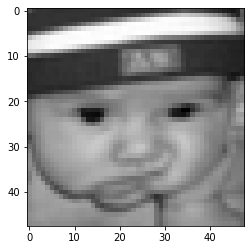

facial emotion: sad


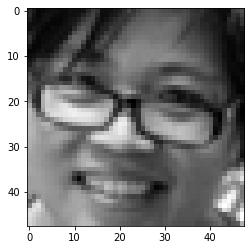

facial emotion: happy


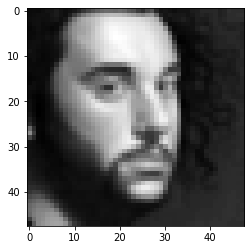

facial emotion: neutral


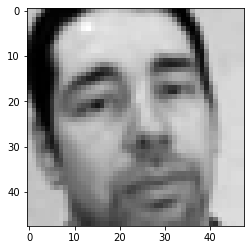

facial emotion: neutral


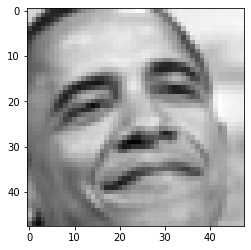

facial emotion: happy


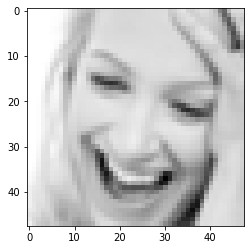

facial emotion: happy


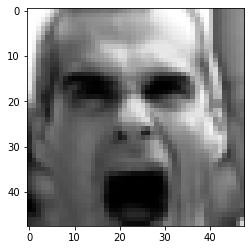

facial emotion: angry


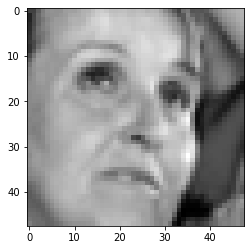

facial emotion: sad


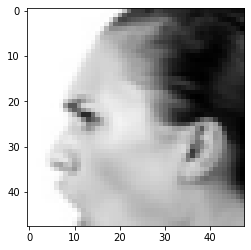

facial emotion: angry


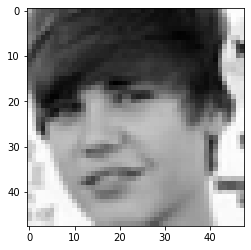

facial emotion: neutral


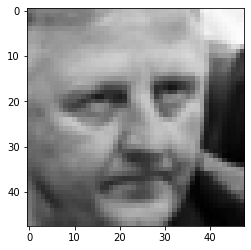

facial emotion: angry


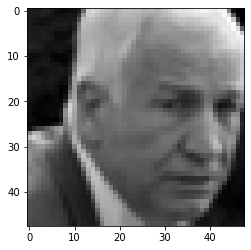

facial emotion: neutral


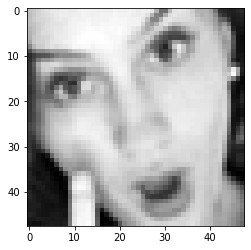

facial emotion: angry


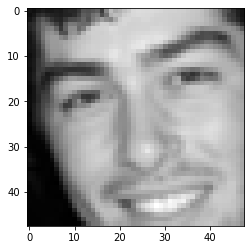

facial emotion: happy


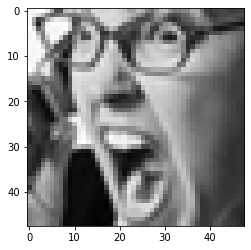

facial emotion: angry


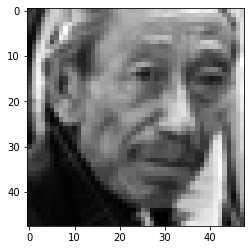

facial emotion: neutral


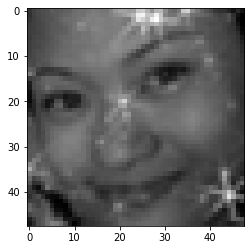

facial emotion: happy


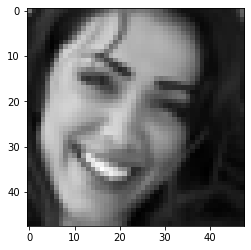

facial emotion: happy


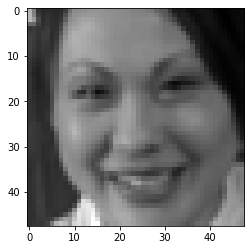

facial emotion: happy


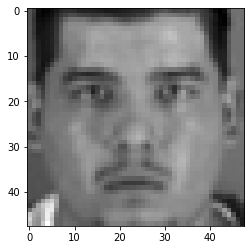

facial emotion: neutral


In [13]:
import matplotlib.pyplot as plt
print(xtrain.shape)
print(ytrain.shape)

print(xtest.shape)
print(ytest.shape)


for x in range(20):
    sample = xtest[x, :]
    sample = sample.reshape(48, 48)

    plt.imshow(sample, cmap='gray')
    plt.show()
    print('facial emotion: %s' % get_emotion(ytest[x, :]))

In [14]:
print(xtrain.shape)
print(ytrain.shape)

print(xtest.shape)
print(ytest.shape)
countAngry, countHappy, countSurprise, countNeutral = 0,0,0,0
for x in range(2520):
    sample = xtest[x, :]
    sample = sample.reshape(48, 48)
    
    #plt.imshow(sample, cmap='gray')
    #plt.show()
    #print('facial emotion: %s' % get_emotion(ytest[x, :]))
    if get_emotion(ytest[x, :]) == 'angry' :
        countAngry = countAngry + 1
    elif get_emotion(ytest[x, :]) == 'sad' :
        countHappy = countHappy + 1
    elif get_emotion(ytest[x, :]) == 'happy' :
        countSurprise = countSurprise + 1
    elif get_emotion(ytest[x, :]) == 'neutral' :
        countNeutral = countNeutral + 1
print('testAngry : ' + str(countAngry) + ', testHappy : ' + str(countHappy)
      +', testSurprise : ' + str(countSurprise) + ', testNeutral : ' + str(countNeutral))
total_test = countAngry + countHappy + countSurprise + countNeutral
print('Total test : ' + str(total_test)+' data.')


(10080, 48, 48, 1)
(10080, 4)
(2520, 48, 48, 1)
(2520, 4)
testAngry : 605, testHappy : 658, testSurprise : 608, testNeutral : 649
Total test : 2520 data.


In [15]:
history = model.fit_generator(data_generator.flow(xtrain, ytrain,
                                            batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/10000
315/315 [==============================] - 27s 84ms/step - loss: 1.4573 - accuracy: 0.3579 - val_loss: 1.4781 - val_accuracy: 0.2575

Epoch 00001: val_loss improved from inf to 1.47809, saving model to Git_Emotion_recog/models/FilterEmotion4ClassesV2/_mini_XCEPTION.01-Model.hdf5
Epoch 2/10000
315/315 [==============================] - 18s 57ms/step - loss: 1.3315 - accuracy: 0.4301 - val_loss: 1.2579 - val_accuracy: 0.4488

Epoch 00002: val_loss improved from 1.47809 to 1.25791, saving model to Git_Emotion_recog/models/FilterEmotion4ClassesV2/_mini_XCEPTION.02-Model.hdf5
Epoch 3/10000
315/315 [==============================] - 18s 56ms/step - loss: 1.2807 - accuracy: 0.4549 - val_loss: 1.5160 - val_accuracy: 0.3956

Epoch 00003: val_loss did not improve from 1.25791
Epoch 4/10000
315/315 [==============================] - 18s 56ms/step - loss: 1.1902 - accuracy: 0.4937 - val_loss: 1.0920 - val_accuracy: 0.5544

Epoch 00004: val_loss improved from 1.25791 to 1.09201, savin

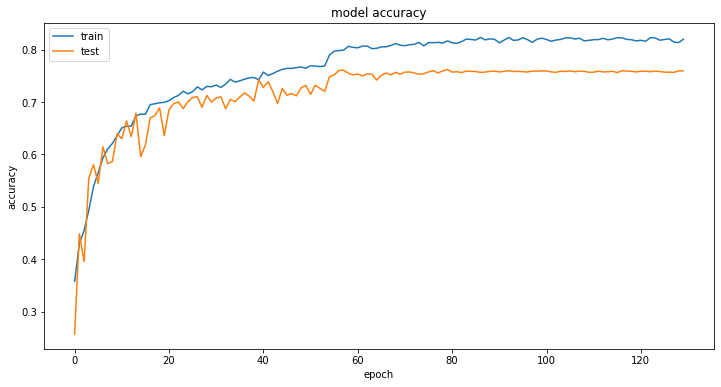

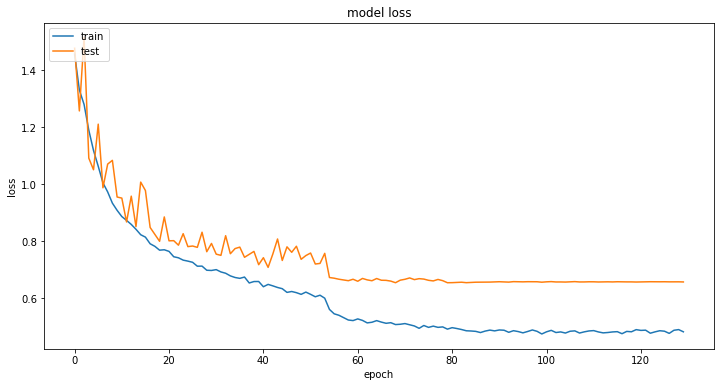

In [16]:


# summarize history for accuracy
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()